In [1]:
## installations
# %pip install pygeocodio
# %pip install colorama
# %pip install python-dotenv
# %pip install CensusData
# %pip install censusdata
# %pip install census
#!pip install us

## imports
from math import isnan
import os
import pandas as pd
from geocodio import GeocodioClient
import requests
import sqlalchemy
import numpy as np

from colorama import Fore, Style
from inspect import getframeinfo, stack
import smtplib, ssl
from datetime import datetime
from pytz import timezone
from sqlalchemy import create_engine

from dotenv import load_dotenv
load_dotenv()
import pickle
import geopandas as gpd
import censusdata as cd
from census import Census

## some additional
import pathlib
import re
import geoplot as gplt
import mapclassify as mc

%matplotlib inline
from shapely.geometry import Point
from geopandas import datasets, GeoDataFrame, read_file
from geopandas.tools import overlay, sjoin
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## keys
key = "a00cb79ec4f97e6760c49740b8ea7a7be6b77bb"
client = GeocodioClient(key)
censuskey = "8105419cada33ca0aaa48b111b8c44b9484e286a"


## path names
PATH_TO_DROPBOX = "../../qss20_finalproj_rawdata/geocontext/"

## intermediate outputs
PATH_TO_INT_OUTPUTS = PATH_TO_DROPBOX + "intermediate/"
PATH_TO_RAW_INPUTS = PATH_TO_DROPBOX + "raw/"

## multiple printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Functions

In [2]:
def myprint(message, is_red="", email_also=""):
    try:
        if email_also != "yes":
            frameinfo = getframeinfo((stack()[1][0]))
            file_and_line_info = Fore.LIGHTBLUE_EX + "  (" + frameinfo.filename.split("/")[-1] + ", line " + str(frameinfo.lineno) + ")" + Style.RESET_ALL
        else:
            file_and_line_info = ""
        if is_red == "red":
            print_red(message + file_and_line_info)
        else:
            print(message + file_and_line_info)
    except:
        print(message + "(there was an error with `myprint`)")
        
def create_address_from(address, city, state, zip):
    return handle_null(address) + ", " + handle_null(city) + " " + handle_null(state) + " " + handle_null(str(zip))

def handle_null(object):
    if pd.isnull(object):
        return ""
    else:
        return str(object)
    
def split_into_parts(a_list, max_items_per_part):
    if len(a_list) < max_items_per_part:
        return [a_list]
    else:
        num_parts = len(a_list) // max_items_per_part
        res = []
        start = 0
        end = max_items_per_part
        for num in range(num_parts):
            res.append(a_list[start:end])

            if num != num_parts - 1:
                start += max_items_per_part
                end += max_items_per_part

        res.append(a_list[end:])
        return res

In [3]:

# geocodes a DataFrame `df`, adding columns for latitude, longitude, accuracy, and accuracy type
# worksite_or_housing is either "worksite" or "housing" and specifies whether to geocode housing or worksite columns
# if `check_previously_geocoded, uses the materialized postgres view `previously_geocoded` to geocode addresses that
# we've already geocoded without using Geocodio so as to save credits
# return the DataFrame with geocoding results columns added

def geocode_table(df, worksite_or_housing, check_previously_geocoded=False):
    myprint(f"Geocoding {worksite_or_housing}...")

    if check_previously_geocoded:
        make_query("REFRESH MATERIALIZED VIEW previously_geocoded")
        
        if worksite_or_housing == "worksite":
            df["address_id"] = df.apply(lambda job: (handle_null(job["street_addr_1_txt"]) + handle_null(job["cty_nm"]) +
                                                     handle_null(job["st_cd"]) + handle_null(job["zip_cd"])).lower(), axis=1)
        else:
            df["address_id"] = df.apply(lambda job: (handle_null(job["HOUSING_ADDRESS_LOCATION"]) + handle_null(job["HOUSING_CITY"]) +
                                                     handle_null(job["HOUSING_STATE"]) + handle_null(job["HOUSING_POSTAL_CODE"])).lower(), axis=1)
        df["previously_geocoded"] = False
        df[f"{worksite_or_housing}_lat"] = None
        df[f"{worksite_or_housing}_long"] = None
        df[f"{worksite_or_housing} accuracy"] = None
        df[f"{worksite_or_housing} accuracy type"] = ""

        errors = 0
        for i, job in df.iterrows():
            # won't work if the full address has certain special characters. should probably fix this but it's rather rare
            try:
                previous_geocode = pd.read_sql(f"""SELECT * FROM previously_geocoded WHERE full_address = '{job["address_id"]}'""", con=engine)
            except:
                previous_geocode = pd.DataFrame()
                print(f"""Failed to query previously_geocoded for address '{job["address_id"]}', the {i + 1}th row.""")
                errors += 1
            if not previous_geocode.empty:
                myprint(f"""'{job["address_id"]}' - the {i + 1}th row - is previously geocoded.""")
                assert len(previous_geocode) == 1
                df.at[i, f"{worksite_or_housing}_lat"] = get_value(previous_geocode, "latitude")
                df.at[i, f"{worksite_or_housing}_long"] = get_value(previous_geocode, "longitude")
                df.at[i, f"{worksite_or_housing} accuracy"] = get_value(previous_geocode, "accuracy")
                df.at[i, f"{worksite_or_housing} accuracy type"] = get_value(previous_geocode, "accuracy_type")
                df.at[i, "previously_geocoded"] = True

        print(f"There were {errors} errors checking for previous geocoding.")
        df = df.drop(columns=["address_id"])

        previously_geocoded = df[df["previously_geocoded"]]
        df = df[~(df["previously_geocoded"])]

        print(f"{len(previously_geocoded)} rows have already been geocoded and {len(df)} rows still need to be geocoded.")

        df = df.drop(columns=["previously_geocoded"])
        previously_geocoded.drop(columns=["previously_geocoded"], inplace=True)

    if not df.empty:

        if worksite_or_housing == "worksite":
            addresses = df.apply(lambda job: create_address_from(job["street_addr_1_txt"], job["cty_nm"], job["st_cd"], job["zip_cd"]), axis=1).tolist()
        elif worksite_or_housing == "housing":
            addresses = df.apply(lambda job: create_address_from(job["HOUSING_ADDRESS_LOCATION"], job["HOUSING_CITY"], job["HOUSING_STATE"], job["HOUSING_POSTAL_CODE"]), axis=1).tolist()
        else:
            print_red_and_email("`worksite_or_housing` parameter in geocode_table function must be either `worksite` or `housing` or `housing addendum`", "Invalid Function Parameter")
            return

        # handles case of more than 10000 addresses - because geocodio api won't batch geocode with more than 10000 addresses at once
        addresses_split = split_into_parts(addresses, 9999)
        geocoding_results = []
        for these_addresses in addresses_split:
            geocoding_results += client.geocode(these_addresses)
        assert len(geocoding_results) == len(addresses)


        latitudes, longitudes, accuracies, accuracy_types, i = [], [], [], [], 0
        for result in geocoding_results:
            try:
                results = result['results'][0]
                accuracies.append(results['accuracy'])
                accuracy_types.append(results['accuracy_type'])
                latitudes.append(results['location']['lat'])
                longitudes.append(results['location']['lng'])
            except:
                accuracies.append(None)
                accuracy_types.append(None)
                latitudes.append(None)
                longitudes.append(None)
            i +=1

        i = len(df.columns)
        df[f"{worksite_or_housing}_lat"] = latitudes
        df[f"{worksite_or_housing}_long"] = longitudes
        df[f"{worksite_or_housing} accuracy"] = accuracies
        df[f"{worksite_or_housing} accuracy type"] = accuracy_types
        myprint(f"Finished geocoding {worksite_or_housing}.")

    if check_previously_geocoded:
        df = df.append(previously_geocoded)

    # # uncomment to save excel file with geocoding results
    # now = datetime.now(tz=timezone('US/Eastern')).strftime("%I.%M%.%S_%p_%B_%d_%Y")
    # df.to_excel(f"geocoded_{now}.xlsx")
    # myprint("Backed up geocoding results")

    return df

# geocodes `df` and returns two dataframes - one with accuratly geocoded rows and one with inaccurate rows
def geocode_and_split_by_accuracy(df, table=""):
    if table == "dol_h2b":
        df = geocode_table(df, "worksite", check_previously_geocoded=True)
    elif table == "housing addendum":
        df = geocode_table(df, "housing", check_previously_geocoded=True)
    elif table == "dol_h2a":
        df = geocode_table(df, "worksite", check_previously_geocoded=True)
        df = geocode_table(df, "housing", check_previously_geocoded=True)
    else:
        df = geocode_table(df, "worksite")
        if "HOUSING_ADDRESS_LOCATION" in df.columns:
            df = geocode_table(df, "housing")
        else:
            print_red_and_email("Not geocoding housing because HOUSING_ADDRESS_LOCATION is not present. This should be fine, and hopefully just means there were only H-2B jobs in today's run, but you may want to check.", "Not geocoding housing today")

    housing_addendum = (table == "housing addendum")
    accurate = df.apply(lambda job: is_accurate(job, housing_addendum=housing_addendum), axis=1)
    accurate_jobs, inaccurate_jobs = df.copy()[accurate], df.copy()[~accurate]
    inaccurate_jobs["fixed"] = False

    myprint(f"There were {len(accurate_jobs)} accurate jobs.\nThere were {len(inaccurate_jobs)} inaccurate jobs.")

    return accurate_jobs, inaccurate_jobs

def geocode_onestate(data, abbr):
    df = data[data["st_cd"] == abbr].copy()
    geo_tab = geocode_table(df, "worksite", check_previously_geocoded=False)
    gdf = gpd.GeoDataFrame(geo_tab, 
                             geometry=gpd.points_from_xy(geo_tab.worksite_long, geo_tab.worksite_lat))
    return(gdf)


def demographics(variables_list, state_code, year = 2016):
    list_dem = c.acs5.state_county_tract(
        variables_list,
        state_fips=state_code,
        year = year,
        county_fips=Census.ALL,
        tract=Census.ALL)
    df = pd.DataFrame(list_dem)
    return df

# Step 1: load raw violations data and geocode

In [4]:
url = "https://enfxfr.dol.gov/data_catalog/WHD/whd_whisard_20210415.csv.zip"
raw_dol = pd.read_csv(url, 
                      index_col=None,
                      dtype={7:'string'})
raw_dol['findings_start_date'] = pd.to_datetime(raw_dol['findings_start_date'], errors='coerce')
raw_dol['findings_end_date'] = pd.to_datetime(raw_dol['findings_end_date'], errors='coerce')
print(f'raw dataframe has {len(raw_dol.columns)} columns and {len(raw_dol)} rows')

raw dataframe has 110 columns and 313928 rows


In [5]:
list_states= ['TX', 'MS', 'LA', 'KY', 'AL', 'TN']
raw_dol_states = raw_dol[raw_dol["st_cd"].isin(list_states)]
raw_dol_states = raw_dol_states[raw_dol_states["h2a_violtn_cnt"] > 0]
raw_dol_states = raw_dol_states[raw_dol_states["ld_dt"] >= "2016-1-1"]
print(f'When we subset to catchment state H2A violations and post 2016, we have {raw_dol_states.shape[0]} rows')

When we subset to catchment state H2A violations and post 2016, we have 329 rows


In [6]:
RUN_GEOCODER = False
if RUN_GEOCODER:
    for one_state in list_states:
        print("starting geocoding for state: " + one_state)
        one_state_result = geocode_onestate(raw_dol_states, one_state)
        path_topickle = PATH_TO_INT_OUTPUTS + one_state + ".p"
        with open(path_topickle, "wb") as name:
            pickle.dump(one_state_result, name)
        name.close()
        print("wrote results for state: " + one_state)
else:
    all_point_pickles = [file for file in os.listdir(PATH_TO_INT_OUTPUTS)
                         if re.match("[A-Z][A-Z].p", file)]
    print("Available pickle files: " + "; ".join(all_point_pickles))
    ## fairly manual but could revise to make more general though tricky with obj naming
    ## reads each pkl from intermediate dir in Dropbox
    MS_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "MS.p", "rb"))
    AL_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "AL.p", "rb"))
    TX_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "TX.p", "rb"))
    KY_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "KY.p", "rb"))
    TN_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "TN.p", "rb"))
    LA_points = pickle.load(open(PATH_TO_INT_OUTPUTS + "LA.p", "rb"))
    print("Finished reading in pickles")
        

Available pickle files: MS.p; LA.p; KY.p; TN.p; TX.p; AL.p
Finished reading in pickles


# Step 2: load tract shapefiles and code each investigation lat/long to its census tract

In [7]:
## Loading shapefiles; refers to entire directory/should be unzipped beforehand
al_shapes = gpd.read_file(PATH_TO_RAW_INPUTS + "tl_2016_01_tract")
ky_shapes = gpd.read_file(PATH_TO_RAW_INPUTS + "tl_2016_21_tract")
la_shapes = gpd.read_file(PATH_TO_RAW_INPUTS + "tl_2016_22_tract")
ms_shapes = gpd.read_file(PATH_TO_RAW_INPUTS + "tl_2016_28_tract")
tn_shapes = gpd.read_file(PATH_TO_RAW_INPUTS + "tl_2016_47_tract")
tx_shapes = gpd.read_file(PATH_TO_RAW_INPUTS + "tl_2016_48_tract")

In [8]:
## get CRS of shapefiles
shapefile_crs = tx_shapes.crs

In [9]:
## intersections while setting the CRS/projection of the 
## points to match the shapefiles CRS; could be made more efficient
## by storing the points and shapes in a length-2 list and then 
## putting that list in a dict with state as key
al_join = sjoin(AL_points.set_crs(shapefile_crs), al_shapes, how="right", op = "intersects")
ky_join = sjoin(KY_points.set_crs(shapefile_crs), ky_shapes, how="right", op = "intersects")
ms_join = sjoin(MS_points.set_crs(shapefile_crs), ms_shapes, how="right", op = "intersects")
la_join = sjoin(LA_points.set_crs(shapefile_crs), la_shapes, how="right", op = "intersects")
tx_join = sjoin(TX_points.set_crs(shapefile_crs), tx_shapes, how="right", op = "intersects")
tn_join = sjoin(TN_points.set_crs(shapefile_crs), tn_shapes, how="right", op = "intersects")

# Step 3: pull ACS demographics

In [10]:
## rj note- may want to embed below in a similar ifelse statement as with the geocoder so not running repeatedly

In [11]:
c = Census(censuskey)
var_names = ["B03001_003E", "B01003_001E", "NAME"]

texas_dem = demographics(var_names, "48")
mississippi_dem = demographics(var_names, "28")
louisiana_dem = demographics(var_names, "22")
alabama_dem = demographics(var_names, "01")
tennessee_dem = demographics(var_names, "47")
kentucky_dem = demographics(var_names, "21")

# Step 4: merge demographics onto all tracts, regardless of count of violations



## 4.1 rowbind demographics and calculate percentages

In [12]:
all_dem = pd.concat([texas_dem, mississippi_dem, louisiana_dem, alabama_dem, tennessee_dem, kentucky_dem])
all_dem["perc_hispanic"] = all_dem["B03001_003E"]/all_dem["B01003_001E"]
all_dem["state_abbrv"] = all_dem["state"].replace({"48": "TX", "28": "MS", "22": "LA", 
                                                   "01": "AL", "47": "TN", "21": "KY"})
all_dem["GEOID_pasted"] = all_dem.state.astype(str) + \
                        all_dem.county.astype(str) + all_dem.tract.astype(str)


## 4.2 Merge demographics onto spatial dataframe with tract geometries, retaining all tracts

In [13]:
all_spatial_tracts = pd.concat([al_join, ky_join, la_join, tx_join,
                               tn_join, ms_join])


In [14]:
print(type(all_spatial_tracts))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [15]:
## rj note- this is where things get converted from a geodataframe
## to a normal dataframe so could try diff join but later i just convert back
all_tracts_wdem = pd.merge(all_dem,
                          all_spatial_tracts,
                          how = "left",
                          left_on = "GEOID_pasted",
                          right_on = "GEOID",
                          suffixes = ["_acsdem", "_tracts"], 
                        indicator = "in_tracts")
all_tracts_wdem.in_tracts.value_counts()
print("Before merging, we had {} Census tracts with demographics".format(len(all_dem.GEOID_pasted.unique())))
print("After merging with polygons, we have {} tracts with demographics".format(len(all_tracts_wdem.GEOID_pasted.unique())))


both          10967
left_only         0
right_only        0
Name: in_tracts, dtype: int64

Before merging, we had 10870 Census tracts with demographics
After merging with polygons, we have 10870 tracts with demographics


## 4.3 Code places to zero violations if not in the spatial points data

In [16]:
## subsets to one with non-zero count of violations so no zeros
raw_dol_states.h2a_violtn_cnt.value_counts(dropna = False)

## after merge, includes NA or tracts without violations
all_tracts_wdem.h2a_violtn_cnt.value_counts(dropna = False)

all_tracts_wdem['h2_viol_include0'] = all_tracts_wdem['h2a_violtn_cnt'].fillna(0, inplace = False)
all_tracts_wdem.h2_viol_include0.value_counts(dropna = False)

1      71
2      43
3      31
4      18
5      17
       ..
21      1
63      1
29      1
70      1
464     1
Name: h2a_violtn_cnt, Length: 71, dtype: int64

NaN      10638
1.0         71
2.0         43
3.0         31
4.0         18
         ...  
54.0         1
57.0         1
30.0         1
111.0        1
183.0        1
Name: h2a_violtn_cnt, Length: 72, dtype: int64

0.0      10638
1.0         71
2.0         43
3.0         31
4.0         18
         ...  
54.0         1
57.0         1
30.0         1
111.0        1
183.0        1
Name: h2_viol_include0, Length: 72, dtype: int64

## 4.4 Create aggregation of violations to tract level and merge with tract polygon

- Group by census tract
- Find total count of H2A violations (sum of the include 0 measure)
- Find total count of places with H2A violations (sum of any > 0)

In [17]:
### data for shading: perc hispanic + viol summary by tract
count_viols_bytract = all_tracts_wdem.groupby('GEOID').agg({'h2_viol_include0': [np.sum, 
                                                        lambda x: sum(x != 0)],
                                                        'perc_hispanic': np.mean,
                                                        'state_abbrv': lambda x: x.unique()}).reset_index()

count_viols_bytract.columns = ['GEOID', 'total_tract_violations', 'total_tract_investigations_wviol', "perc_hispanic",
                              "state_abbrv"]
count_viols_bytract.head() # max is 716 violations in that tract; 8 unique investigations
count_viols_bytract.describe()


## merge back on:
## tract polygon
## and make sure geodataframe
count_viols_bytract_wpoly = gpd.GeoDataFrame(pd.merge(count_viols_bytract,
                                    all_spatial_tracts[['GEOID', 'geometry']],
                                    how = "left",
                                    on = "GEOID"),
                                geometry = 'geometry')
## add tract centroid as a column
## in case you need point location at tract level
## based on here this is using a metric CRS rather than the shapefile CRS: https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas
count_viols_bytract_wpoly['tract_centroid'] = count_viols_bytract_wpoly.geometry.to_crs(epsg = 3395).centroid
count_viols_bytract_wpoly.head()


,GEOID,total_tract_violations,total_tract_investigations_wviol,perc_hispanic,state_abbrv
0,01001020100,0.0,0.0,0.026368,AL
1,01001020200,0.0,0.0,0.012750,AL
2,01001020300,0.0,0.0,0.072704,AL
3,01001020400,0.0,0.0,0.088977,AL
4,01001020500,0.0,0.0,0.009498,AL


,total_tract_violations,total_tract_investigations_wviol,perc_hispanic
count,10870.000000,10870.000000,10780.000000
mean,0.741490,0.030267,0.206977
std,14.882932,0.250318,0.263416
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.020740
50%,0.000000,0.000000,0.086414
75%,0.000000,0.000000,0.291376
max,716.000000,8.000000,1.000000


,GEOID,total_tract_violations,total_tract_investigations_wviol,perc_hispanic,state_abbrv,geometry,tract_centroid
0,01001020100,0.0,0.0,0.026368,AL,"POLYGON ((-86.51038 32.47225, -86.51031 32.472...",POINT (-9628031.161 3803171.314)
1,01001020200,0.0,0.0,0.012750,AL,"POLYGON ((-86.48127 32.47744, -86.48126 32.477...",POINT (-9626172.077 3802785.422)
2,01001020300,0.0,0.0,0.072704,AL,"POLYGON ((-86.47087 32.47573, -86.47084 32.475...",POINT (-9624704.284 3802940.363)
3,01001020400,0.0,0.0,0.088977,AL,"POLYGON ((-86.45394 32.49318, -86.45372 32.493...",POINT (-9622860.260 3802490.475)
4,01001020500,0.0,0.0,0.009498,AL,"POLYGON ((-86.43842 32.44973, -86.43838 32.449...",POINT (-9620526.662 3800761.563)


## 4.5 For places with any violations, merge that aggregated data onto worksite lat/long 

In [18]:
exact_viol_location_wtract = pd.merge(all_spatial_tracts.loc[all_spatial_tracts.case_id.notnull(),
                                    ['case_id', 'worksite_lat',
                                    'worksite_long', 'GEOID', 'h2a_violtn_cnt']], # can add more cols here
                                    count_viols_bytract_wpoly,
                                    on = "GEOID",
                                    how = "left").drop_duplicates()

## here discusses alternate way for lat/long -> points: https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
exact_viol_location_wtract['geometry'] = [Point(xy) for xy in
                                                zip(exact_viol_location_wtract['worksite_long'],
                                                exact_viol_location_wtract['worksite_lat'])]

exact_viol_location_wtract.head()

,case_id,worksite_lat,worksite_long,GEOID,h2a_violtn_cnt,total_tract_violations,total_tract_investigations_wviol,perc_hispanic,state_abbrv,geometry,tract_centroid
0,1860004.0,32.874088,-86.707798,01021060600,1.0,91.0,3.0,0.054638,AL,POINT (-86.70780 32.87409),POINT (-9655658.081 3842016.697)
3,1696089.0,32.773909,-86.719443,01021060600,73.0,91.0,3.0,0.054638,AL,POINT (-86.71944 32.77391),POINT (-9655658.081 3842016.697)
6,1860009.0,32.780891,-86.722257,01021060600,17.0,91.0,3.0,0.054638,AL,POINT (-86.72226 32.78089),POINT (-9655658.081 3842016.697)
9,1860006.0,32.850183,-86.626817,01021060102,3.0,4.0,2.0,0.064841,AL,POINT (-86.62682 32.85018),POINT (-9646617.749 3855047.759)
11,1860016.0,32.858844,-86.640349,01021060102,1.0,4.0,2.0,0.064841,AL,POINT (-86.64035 32.85884),POINT (-9646617.749 3855047.759)


## 4.6 Write pkl to intermediate folder in Dropbox

May need to convert back to spatial df at read in


In [19]:
count_viols_bytract_wpoly.to_pickle(PATH_TO_INT_OUTPUTS + "count_viols_bytract_wpoly.p")
exact_viol_location_wtract.to_pickle(PATH_TO_INT_OUTPUTS + "exact_viol_location_wtract.p")


# 5. Plotting

Uses this package: https://residentmario.github.io/geoplot/quickstart/quickstart.html

In [20]:
## subset to alabama
alabama_plot = count_viols_bytract_wpoly[count_viols_bytract_wpoly.state_abbrv == "AL"].copy()
alabama_plot.head()

alabama_viol = exact_viol_location_wtract[exact_viol_location_wtract.state_abbrv == "AL"].copy()
alabama_viol.head()

,GEOID,total_tract_violations,total_tract_investigations_wviol,perc_hispanic,state_abbrv,geometry,tract_centroid
0,01001020100,0.0,0.0,0.026368,AL,"POLYGON ((-86.51038 32.47225, -86.51031 32.472...",POINT (-9628031.161 3803171.314)
1,01001020200,0.0,0.0,0.012750,AL,"POLYGON ((-86.48127 32.47744, -86.48126 32.477...",POINT (-9626172.077 3802785.422)
2,01001020300,0.0,0.0,0.072704,AL,"POLYGON ((-86.47087 32.47573, -86.47084 32.475...",POINT (-9624704.284 3802940.363)
3,01001020400,0.0,0.0,0.088977,AL,"POLYGON ((-86.45394 32.49318, -86.45372 32.493...",POINT (-9622860.260 3802490.475)
4,01001020500,0.0,0.0,0.009498,AL,"POLYGON ((-86.43842 32.44973, -86.43838 32.449...",POINT (-9620526.662 3800761.563)


,case_id,worksite_lat,worksite_long,GEOID,h2a_violtn_cnt,total_tract_violations,total_tract_investigations_wviol,perc_hispanic,state_abbrv,geometry,tract_centroid
0,1860004.0,32.874088,-86.707798,01021060600,1.0,91.0,3.0,0.054638,AL,POINT (-86.70780 32.87409),POINT (-9655658.081 3842016.697)
3,1696089.0,32.773909,-86.719443,01021060600,73.0,91.0,3.0,0.054638,AL,POINT (-86.71944 32.77391),POINT (-9655658.081 3842016.697)
6,1860009.0,32.780891,-86.722257,01021060600,17.0,91.0,3.0,0.054638,AL,POINT (-86.72226 32.78089),POINT (-9655658.081 3842016.697)
9,1860006.0,32.850183,-86.626817,01021060102,3.0,4.0,2.0,0.064841,AL,POINT (-86.62682 32.85018),POINT (-9646617.749 3855047.759)
11,1860016.0,32.858844,-86.640349,01021060102,1.0,4.0,2.0,0.064841,AL,POINT (-86.64035 32.85884),POINT (-9646617.749 3855047.759)


### First: plot location of worksite violations/total number of site-level violations relative to bare geometry

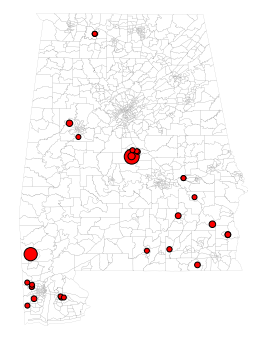

In [21]:

## even though it's in the geoplot package, seems to follow similar
## syntax to seaborn: https://seaborn.pydata.org/generated/seaborn.pointplot.html
al_vionly = gplt.polyplot(alabama_plot,
                         edgecolor = "grey",
                    linewidth = 0.1)
gplt.pointplot(
      alabama_viol,
      ax=al_vionly,
    color = "Red",
    scale = 'h2a_violtn_cnt',
    edgecolors = "black",
    limits = (5, 15)) # i think in order to increase size, need to add a dataframe col 


### Second: shade by perc hispanic 

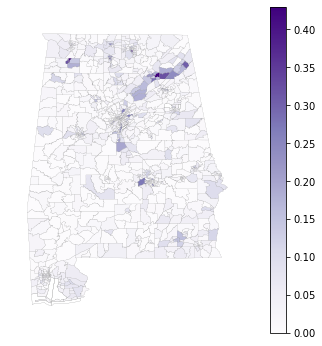

In [22]:
al_vionly = gplt.polyplot(alabama_plot,
                         edgecolor = "grey",
                         linewidth = 0.1)
gplt.choropleth(
    alabama_plot,
    ax=al_vionly,
    hue='perc_hispanic', 
    cmap='Purples',
    edgecolor='grey',
    linewidth = .1,
    legend=True)



### Third: try overlaying the locations on top of the choropleth:

Unresolved issue: for some reason dots go behind the plot rather than on top
Should definitely be some way to fix; tried feeding cpleth to ax and that didn't help

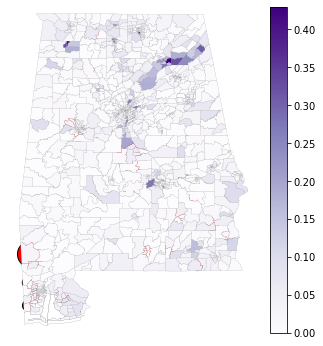

In [23]:
al_vionly = gplt.polyplot(alabama_plot,
                         edgecolor = "grey",
                         linewidth = 0.1)
cpleth = gplt.choropleth(
    alabama_plot,
    ax=al_vionly,
    hue='perc_hispanic', 
    cmap='Purples',
    edgecolor='grey',
    linewidth = .1,
    legend=True)

gplt.pointplot(
      alabama_viol,
      ax=cpleth,
    color = "Red",
    scale = 'h2a_violtn_cnt',
    edgecolors = "black",
    limits = (10, 30))

### Fourth: shading tract by tract-level sum of violations

In [24]:
alabama_plot.total_tract_violations.value_counts()

0.0     1160
1.0        7
2.0        4
4.0        4
3.0        3
12.0       3
91.0       3
6.0        2
11.0       1
60.0       1
7.0        1
Name: total_tract_violations, dtype: int64

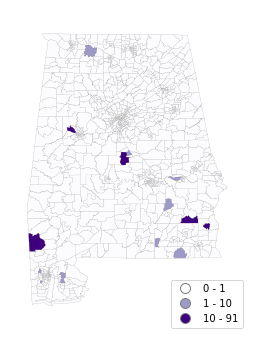

In [25]:
al_all = gplt.polyplot(alabama_plot,
                         edgecolor = "grey",
                         linewidth = 0.1)
## define bins- can change to another manual or a more automatic
## using mapclassify
shading_scheme = mc.UserDefined(alabama_plot['total_tract_violations'], bins = [1, 10])
# shading_scheme
gplt.choropleth(
    alabama_plot,
    ax=al_all,
    hue='total_tract_violations', 
    cmap='Purples',
    scheme = shading_scheme,
    linewidth = 0.1,
    edgecolor = "grey", legend = True)

# Older plotting code

In [26]:

# fig, ax = plt.subplots(figsize=(12,12))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
# alabama_plot.plot(ax=ax, 
#                 column='perc_hispanic', 
#                 cmap='Purples',
#                 edgecolor='grey',
#                 linewidth = .1,
#                 legend=True, 
#                 cax=cax,
#                 missing_kwds={"color": "lightgrey"})
# #alabama_viol.plot(x = 'worksite_long', y = 'worksite_lat', marker = "*", color = 'r')
# #alabama_to_merge.plot(ax=ax, column = "h2a_violtn_cnt", color = "red")
# #ax.scatter(x = "worksite_long", y = "worksite_lat", marker="*", color='r', alpha=0.7, s = "h2a_violtn_cnt")
# #alabama_plot.plot(x = "worksite_long", y = "worksite_lat", column = "h2a_violtn_cnt", ax = ax, kind = "scatter")
# ax.set_title('Alabama', fontsize=20)
# fig.patch.set_visible(False)
# ax.axis('off')
# plt.tight_layout()
# #plt.savefig('images/choropleth.png')